In [118]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run runme_terminus_sensitivity_basic.m tutorial translted from Matlab to Python
# Mikayla Pascual 06/16/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *

In [43]:
# Load some mat files to use later
vel_mat = loadmat('Cheat_matfiles/vel.mat')
hmaxVertices_mat = loadmat('Cheat_matfiles/hmaxVertices.mat')
param_mat = loadmat('Cheat_matfiles/param.mat')

velx = vel_mat['velx']
vely = vel_mat['vely']
vel = vel_mat['vel']

hmaxVertices = hmaxVertices_mat['hmaxVertices']


In [44]:
# Setup
region = 'SAtoES';
start_year = 1985;

# Mesh sizing
triangleresolution = 1000;
hmin = 300;
hmax = 10000;

# Mesh
md = model()
md = triangle(md,'./Exp/' +region+ '.exp',triangleresolution) # set up mesh

md = bamg(md,'hmin',hmin,'hmax',hmax,'field',vel,'err',2,'hmaxVertices',hmaxVertices);

#savevars('./Models/' +region+ '_mesh', 'md', md)

# 

/efs/issm/issm/trunk-jpl/src/m/plot/plotmodel.py:123: MatplotlibDeprecationWarning: 
The 'add_all' parameter of __init__() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'add_all', they should be passed as keyword, not positionally.
  axgrid = ImageGrid(


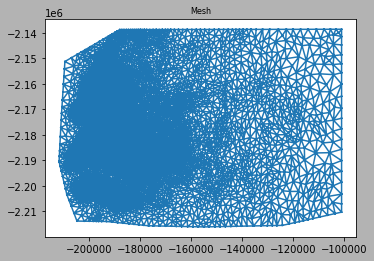

In [45]:
# Plot mesh
plotmodel(md,'data','mesh')

In [60]:

md.geometry.bed = param_mat['geometry_bed']
md.geometry.surface = param_mat['geometry_surface']
md.geometry.base = param_mat['geometry_base']
md.mask.ice_levelset = param_mat['mask_ice_levelset']
md.mask.groundedice_levelset = param_mat['mask_groundedice_levelset']
md.inversion.vx_obs = param_mat['inversion_vx_obs']
md.inversion.vy_obs = param_mat['inversion_vy_obs']
md.inversion.vel_obs = param_mat['inversion_vel_obs']
md.initialization.vx = param_mat['initialization_vx']
md.initialization.vy = param_mat['initialization_vy']
md.initialization.vz = param_mat['initialization_vz']
md.initialization.vel = param_mat['initialization_vel']
md.friction.coefficient = param_mat['friction_coefficient']
md.materials.rheology_n = param_mat['rheology_n']
md.materials.rheology_B = param_mat['rheology_B']
md.basalforcings.groundedice_melting_rate = param_mat['basalforcings_groundedice_melting_rate']
md.basalforcings.floatingice_melting_rate = param_mat['basalforcings_floatingice_melting_rate']
md.smb.mass_balance = param_mat['smb_mass_balance']
md.basalforcings.geothermalflux = param_mat['basalforcings_geothermalflux']
md.stressbalance.spcvx = param_mat['stressbalance_spcvx']
md.stressbalance.spcvy = param_mat['stressbalance_spcvy']
md.stressbalance.spcvz = param_mat['stressbalance_spcvz']
md.stressbalance.referential = param_mat['stressbalance_referential']
md.stressbalance.loadingforce = param_mat['stressbalance_loadingforce']
md.masstransport.spcthickness = param_mat['masstransport_spcthickness']


In [120]:
# Step 3
## Inversion
#md = loadmodel('./Models/' +region+ '_Param.mat');
# Control general
#md.inversion=m1qn3inversion(md.inversion);
md.inversion.iscontrol=1;
md.verbose.solution=False
md.verbose.control=True

# Cost functions
md.inversion.cost_functions=[101,103,501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)]);
md.inversion.cost_functions_coefficients[:,0]=2000;
md.inversion.cost_functions_coefficients[:,1]=40;
md.inversion.cost_functions_coefficients[:,2]=1.6e-06;

#Where vel==0, set coefficients to 0 (i.e., don't try to match this in model disp(['Removing vel==0 obs from inversion']);
#pos = find(md.inversion.vel_obs == 0);
#md.inversion.cost_functions_coefficients[pos,1] = 0;
#md.inversion.cost_functions_coefficients[pos,2] = 0;

#Controls
md.inversion.control_parameters={'FrictionCoefficient'};
md.inversion.maxsteps=50;
md.inversion.maxiter =50;
md.inversion.min_parameters=0.05*np.ones([md.mesh.numberofvertices,1]);
md.inversion.max_parameters=200*np.ones([md.mesh.numberofvertices,1]);
md.inversion.control_scaling_factors=1;

#Set basal friction coefficient initial guess to something low at front
filename = ['Exp/' +region+ '_coeffront.exp'];
if os.path.exists(filename,'file'):
  disp(['Correcting basal friction coefficient initial guess for front inconsistencies']),
  flags = ContourToNodes(md.mesh.x,md.mesh.y,filename,2),
  #flags = md.inversion.vel_obs == 0;
  pos1 = find(flags), pos2 = find(~flags),
  md.friction.coefficient[pos1,:] = 10

  md.inversion.max_parameters[pos1] = md.friction.coefficient[pos1,:];
end

#Additional parameters
md.stressbalance.restol=0.01;
md.stressbalance.reltol=0.1;
md.stressbalance.abstol=NaN;
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

# Go solve
md.verbose.solution=1;
md.cluster = cluster;
md.settings.waitonlock = waitonlock;
md = solve(md,'Stressbalance');

# Save
#savemodel(org,md);

SyntaxError: cannot assign to function call (<ipython-input-120-582dd42645a5>, line 36)